# Test evaluations

In [1]:
from os.path import realpath
from pathlib import Path
import pandas as pd
import itertools
import json
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

def load_json(path):
    with open(path) as f:
        cfg = json.load(f)
    return cfg

RUNS_DIR = Path(realpath('.')) / 'runs'
if not 'dage/runs' in str(RUNS_DIR):
    RUNS_DIR = Path(realpath('.')).parent / 'runs'
assert('dage/runs' in str(RUNS_DIR))

In [2]:
def load_cls_rep_paths_new(
    method,
    experiment_id,
    prefix=None,
    config_dict={},
):
    d = RUNS_DIR / method / experiment_id
    paths = []
    for item in d.glob('*'):
        if (item.is_dir()):
            if config_dict:
                config = load_json(item / 'config.json')
                if not all([config[k]==v for k,v in config_dict.items()]):
                    continue
            if prefix:
                if not item.name.startswith(prefix):
                    continue
            paths.append( item / 'report.json' ) 
    return sorted(paths)

def get_score_new(
    report_paths,
    metric:str='precision',
    avg_types=['macro avg', 'weighted avg'],
    map_col_name= lambda n: n
):
    reports = [ pd.read_json(p) for p in report_paths ]
    score = pd.DataFrame(
        [[r[avgt][metric] for avgt in avg_types]
         for r in reports
        ],
        columns = [ map_col_name(avgt) for avgt in avg_types]
    ) 
    return score


def get_score_combinations_new(
    method,
    experiment_id,
    config_key=None,
    config_value=None,
    config_dict={},
    domains=['A','W','D'], 
    metric:str='recall',
    avg_types=['macro avg'],
):
    if config_key and config_value:
        config_dict[config_key] = config_value
        
    combos = [c for c in itertools.product(domains, repeat=2) if c[0] != c[1]]
    scores = [
        get_score_new(
            report_paths=load_cls_rep_paths_new(method, experiment_id, '{}{}'.format(c[0],c[1]), config_dict),
            metric=metric,
            avg_types=avg_types,
            map_col_name=lambda n: '{}->{}'.format(c[0],c[1]),
        )
        for c in combos
    ]
    return pd.concat(scores, sort=False)


def present(df, name):
    df = df.describe().T[['mean','std']]
    tot_mean = df.mean()[['mean']]
    
    toStr = lambda s: f'{s:.2f}'
    df = df['mean'].map(toStr) + ' ±' + df['std'].map(toStr)
    df = pd.concat([df,tot_mean[['mean']]])
    return pd.DataFrame(df, columns=[name]).T


def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

## Tune source only
In this experiment, we tune a VGG16-network pretrained on ImageNet with all available source data.
The target data is used for validation (during training) and test.

In [3]:
tune_source_no_aug_scores = get_score_combinations_new(
    method='tune_source',
    experiment_id='tune_source_no_aug',
)*100
tune_source_no_aug_scores.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,62.255293,2.876099,58.703566,60.118168,62.317043,64.882089,65.255601
A->W,5.0,53.909982,1.816761,51.745806,52.443511,54.047886,55.303047,56.009660
D->A,5.0,37.601127,2.356256,34.128049,36.512041,38.335136,38.775862,40.254545
D->W,5.0,90.982524,2.225432,87.885781,89.989964,90.893983,92.571363,93.571528
W->A,5.0,42.579908,1.533883,40.575395,41.629445,42.976339,43.131344,44.587021
W->D,5.0,98.707230,0.655752,98.064412,98.263400,98.634153,98.822325,99.751861


In [4]:
tune_source_scores = get_score_combinations_new(
    method='tune_source',
    experiment_id='tune_source_with_aug',
)*100
tune_source_scores.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,65.859347,2.230132,63.796151,64.761948,65.003669,66.188868,69.546098
A->W,5.0,56.567206,2.084737,53.898678,54.758035,57.814545,57.853058,58.511712
D->A,5.0,41.696940,1.640651,39.190639,41.082026,42.081671,42.737236,43.393128
D->W,5.0,92.875348,1.169019,90.854845,92.890177,93.381241,93.585405,93.665070
W->A,5.0,41.163056,2.133029,38.413584,40.117469,40.801652,42.617711,43.864865
W->D,5.0,98.691223,0.818735,97.452336,98.443617,98.762161,99.201229,99.596774


### Gradual Unfreeze Fine-tuning

In [5]:
ft_src_grad_unf_0_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_0',
)*100
ft_src_grad_unf_0_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,65.889501,3.74535,60.472616,63.650057,67.380143,68.460982,69.483704


In [6]:
ft_src_grad_unf_2_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_2',
)*100
ft_src_grad_unf_2_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.078229,2.801691,62.942111,65.876221,67.375394,69.438023,69.759397


In [7]:
ft_src_grad_unf_3_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_3',
)*100
ft_src_grad_unf_3_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.732249,2.62079,64.545128,65.210037,69.486343,69.542442,69.877297


In [8]:
ft_src_grad_unf_4_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_4',
)*100
ft_src_grad_unf_4_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.735473,2.193459,64.569827,66.44739,68.603821,69.090516,69.96581


In [9]:
ft_src_grad_unf_6_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_6',
)*100
ft_src_grad_unf_6_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.954058,1.763461,65.899232,67.503943,67.67719,67.918712,70.771212


In [10]:
ft_src_grad_unf_7_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_7',
)*100
ft_src_grad_unf_7_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,68.33378,2.303235,65.440109,66.380372,69.232904,69.844706,70.770809


In [11]:
ft_src_grad_unf_8_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_8',
)*100
ft_src_grad_unf_8_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,68.730472,2.277957,65.965728,67.05596,68.693416,70.58883,71.348427


In [12]:
ft_src_grad_unf_10_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_10',
)*100
ft_src_grad_unf_10_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,4.0,69.595584,2.435421,66.165178,69.075152,70.150045,70.670477,71.917067


In [13]:
ft_src_grad_unf_11_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_11',
)*100
ft_src_grad_unf_11_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,4.0,69.571248,1.186921,68.231463,68.911341,69.50811,70.168017,71.037308


In [14]:
ft_src_grad_unf_12_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_12',
)*100
ft_src_grad_unf_12_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,4.0,70.071983,0.610344,69.325293,69.700486,70.169348,70.540845,70.623943


### Coarse gradual unfreeze

In [15]:
tune_source_vgg16_aug_coarse_grad = get_score_combinations_new(
    method='tune_source',
    experiment_id='vgg16_aug_coarse_grad_ft',
)*100
tune_source_vgg16_aug_coarse_grad.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,66.636605,2.966424,61.512586,66.844356,67.688503,68.164576,68.973006
A->W,5.0,59.793897,2.125821,57.034714,59.304191,59.575454,60.084539,62.970588
D->A,5.0,42.816493,5.218414,33.990533,42.159687,45.591694,45.722539,46.618014
D->W,5.0,92.333845,2.764590,88.024718,91.065796,94.105682,94.148213,94.324815
W->A,5.0,43.998664,0.658633,43.309881,43.468084,44.044374,44.205728,44.965251
W->D,5.0,98.540254,1.236710,97.172397,97.742034,98.109417,99.677419,100.000000


In [16]:
tune_source_resnet101_aug_coarse_grad = get_score_combinations_new(
    method='tune_source',
    experiment_id='resnet101v2_aug_coarse_grad_ft',
)*100
tune_source_resnet101_aug_coarse_grad.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,72.751316,1.454845,71.240210,71.955371,72.341727,73.189988,75.029284
A->D,5.0,74.969336,1.329631,73.364764,73.919061,75.074968,75.985552,76.502338
W->A,5.0,59.596429,1.113659,58.532945,58.585823,59.465619,60.274189,61.123567
W->D,5.0,97.773171,0.733757,96.847018,97.292184,97.735732,98.396254,98.594667
D->A,5.0,60.118268,0.897086,59.117722,59.499037,59.863154,60.978827,61.132598
D->W,5.0,93.719617,1.281476,92.249463,92.427076,94.390690,94.543016,94.987839


### Comparison

In [17]:
grad_unfreeze_source_results = pd.DataFrame({ 
    '0'  : ft_src_grad_unf_0_vgg16['A->D'],
    '2'  : ft_src_grad_unf_2_vgg16['A->D'],
    '3'  : ft_src_grad_unf_3_vgg16['A->D'],
    '4'  : ft_src_grad_unf_4_vgg16['A->D'],
    '6'  : ft_src_grad_unf_6_vgg16['A->D'],
    '7'  : ft_src_grad_unf_7_vgg16['A->D'],
    '8'  : ft_src_grad_unf_8_vgg16['A->D'],
    '10' : ft_src_grad_unf_10_vgg16['A->D'],
    '11' : ft_src_grad_unf_11_vgg16['A->D'],
    '12' : ft_src_grad_unf_12_vgg16['A->D'],
#     '12_coarse'  : tune_source_vgg16_aug_coarse_grad['A->D'].dropna(),
})

grad_unfreeze_source_results

,0,2,3,4,6,7,8,10,11,12
0,63.650057,62.942111,65.210037,66.447390,67.918712,65.440109,67.055960,66.165178,68.231463,69.325293
1,60.472616,65.876221,64.545128,64.569827,65.899232,66.380372,65.965728,70.045143,69.137966,70.623943
2,67.380143,67.375394,69.486343,68.603821,67.677190,69.844706,70.588830,70.254947,71.037308,69.825551
3,69.483704,69.759397,69.877297,69.090516,70.771212,70.770809,71.348427,71.917067,69.878254,70.513146
4,68.460982,69.438023,69.542442,69.965810,67.503943,69.232904,68.693416,NaN,NaN,NaN


In [18]:
grad_unfreeze_source_results.describe().T

,count,mean,std,min,25%,50%,75%,max
0,5.0,65.889501,3.745350,60.472616,63.650057,67.380143,68.460982,69.483704
2,5.0,67.078229,2.801691,62.942111,65.876221,67.375394,69.438023,69.759397
3,5.0,67.732249,2.620790,64.545128,65.210037,69.486343,69.542442,69.877297
4,5.0,67.735473,2.193459,64.569827,66.447390,68.603821,69.090516,69.965810
6,5.0,67.954058,1.763461,65.899232,67.503943,67.677190,67.918712,70.771212
7,5.0,68.333780,2.303235,65.440109,66.380372,69.232904,69.844706,70.770809
8,5.0,68.730472,2.277957,65.965728,67.055960,68.693416,70.588830,71.348427
10,4.0,69.595584,2.435421,66.165178,69.075152,70.150045,70.670477,71.917067
11,4.0,69.571248,1.186921,68.231463,68.911341,69.508110,70.168017,71.037308
12,4.0,70.071983,0.610344,69.325293,69.700486,70.169348,70.540845,70.623943


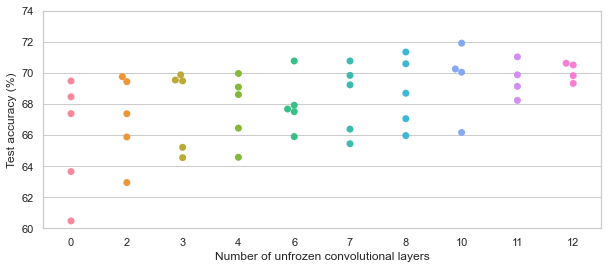

In [19]:
plt.figure(figsize=(10,4))
sns.set()
sns.set_style("whitegrid")
sns.set_palette("Spectral")
# ax = sns.violinplot(data=grad_unfreeze_source_results, width=1)
# ax = sns.boxplot(data=grad_unfreeze_source_results, width=0.5)
# ax = sns.swarmplot(data=grad_unfreeze_source_results, color="0.25")
ax = sns.swarmplot(data=grad_unfreeze_source_results, size=7)
plt.xlabel('Number of unfrozen convolutional layers')
plt.ylabel('Test accuracy (%)')
plt.ylim((60,74))
plt.savefig('gradual-unfreeze-AD.pdf')  

## Tune source and target

### Coarse gradual unfreeze 

In [20]:
tune_target_vgg16_aug_coarse_grad_ft = get_score_combinations_new(
    method='tune_target',
    experiment_id='vgg16_aug_coarse_grad_ft',
)*100
tune_target_vgg16_aug_coarse_grad_ft.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,71.354832,2.047845,69.217956,69.598614,71.136240,72.852380,73.968967
A->W,5.0,73.989078,4.948449,70.062192,71.046410,71.095686,75.883947,81.857153
D->A,5.0,56.201621,3.611262,53.372360,53.476973,54.126970,58.724620,61.307181
D->W,5.0,95.869260,1.167603,95.146474,95.190651,95.300098,95.804594,97.904483
W->A,5.0,50.226811,2.631192,46.918136,48.885330,49.591069,52.335316,53.404202
W->D,5.0,99.108672,0.806583,97.709293,99.327620,99.354030,99.354030,99.798387


In [21]:
tune_target_resnet101v2_aug_coarse_grad_ft = get_score_combinations_new(
    method='tune_target',
    experiment_id='resnet101v2_aug_coarse_grad_ft',
)*100
tune_target_resnet101v2_aug_coarse_grad_ft.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,6.0,86.200014,1.825390,84.220063,85.121348,85.722943,86.918689,89.296046
A->W,5.0,86.637348,1.054278,84.906934,86.629824,86.729457,87.249601,87.670926
D->A,5.0,62.905532,1.268804,61.641015,61.780017,62.662449,64.067289,64.376890
D->W,5.0,94.625185,0.317125,94.348822,94.413338,94.498291,94.738139,95.127337
W->A,5.0,60.932032,0.721214,60.024654,60.404908,61.155426,61.224453,61.850721
W->D,5.0,98.268413,0.487107,97.440673,98.249685,98.422594,98.604908,98.624207


## CCSA

In [22]:
ccsa_tuned_vgg16 = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_vgg16_tuned',
)*100
ccsa_tuned_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,87.535622,1.485454,86.590828,86.759887,86.860938,87.317571,90.148886
A->D,5.0,84.840757,2.144342,82.449100,83.714239,84.155303,85.918205,87.966936
W->A,5.0,64.011722,1.595328,61.740131,63.152612,64.371540,65.001105,65.793222
W->D,5.0,98.594448,0.380161,98.042588,98.404127,98.720475,98.776798,99.028251
D->A,5.0,66.457656,1.877848,64.241496,64.998860,67.016956,67.040978,68.989991
D->W,5.0,97.191010,0.648243,96.216220,96.938034,97.279134,97.691885,97.829776


## d-SNE

In [23]:
dsne_tuned_vgg16 = get_score_combinations_new(
    method='dsne',
    experiment_id='dsne_vgg16_tuned',
)*100
dsne_tuned_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,88.708650,1.940367,86.354795,87.885453,88.011103,89.994425,91.297476
A->D,5.0,86.477079,2.513476,83.330158,84.163633,88.084763,88.336852,88.469990
W->A,5.0,63.936340,1.165632,62.540055,63.063393,63.893964,64.934677,65.249609
W->D,5.0,99.000907,0.495231,98.602151,98.759434,98.858472,98.924731,99.859748
D->A,5.0,65.942406,1.144120,64.980919,65.150586,65.363730,66.546855,67.669942
D->W,5.0,97.575566,0.710516,96.841490,97.091191,97.400872,97.922209,98.622067


## DAGE

In [24]:
dage_lda_tuned_vgg16 = get_score_combinations_new(
    method='dage',
    experiment_id='dage_lda_vgg16_tuned',
)*100
dage_lda_tuned_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,87.817379,2.312507,85.304558,86.117817,87.190956,90.026386,90.447180
A->D,5.0,85.915320,2.826513,82.418740,83.761378,86.578523,87.356686,89.461275
W->A,5.0,64.153106,1.228216,62.457654,63.885081,63.977881,64.601998,65.842916
W->D,5.0,99.487739,0.445585,98.924731,99.127289,99.680536,99.706138,100.000000
D->A,5.0,66.240828,1.426281,65.059623,65.065414,65.873481,66.732370,68.473251
D->W,5.0,97.921389,0.586013,97.172466,97.551199,97.879514,98.499196,98.504572


In [25]:
dage_mfa_tuned_vgg16 = get_score_combinations_new(
    method='dage',
    experiment_id='dage_mfa_vgg16_tuned',
)*100
dage_mfa_tuned_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,88.108995,1.975165,85.598601,87.056135,87.992410,89.109180,90.788650
A->D,5.0,83.568688,3.431887,79.554681,81.165066,83.338754,85.652749,88.132190
W->A,5.0,63.742269,1.688643,61.024040,63.574045,64.073486,64.465509,65.574265
W->D,6.0,99.511899,0.380837,98.861284,99.440660,99.520804,99.696120,100.000000
D->A,5.0,65.877713,1.650009,63.854054,65.196817,65.446891,66.661057,68.229747
D->W,5.0,96.630978,1.394311,94.886371,95.747716,96.691853,97.342561,98.486390


## Summary

### Final results

In [26]:
df_vgg16_tuned = pd.concat([
    present(tune_source_vgg16_aug_coarse_grad, 'FT-Source (VGG16)'),
    present(tune_target_vgg16_aug_coarse_grad_ft, 'FT-Target (VGG16)'),
    present(ccsa_tuned_vgg16, 'CCSA (VGG16)'),
    present(dsne_tuned_vgg16, 'd-SNE (VGG16)'),
    present(dage_lda_tuned_vgg16, 'DAGE-LDA (VGG16)'),
    present(dage_mfa_tuned_vgg16, 'DAGE-MFA (VGG16)'),
])
df_vgg16_tuned.style.apply(highlight_max)

,A->W,A->D,W->A,W->D,D->A,D->W,mean
FT-Source (VGG16),59.79 ±2.13,66.64 ±2.97,44.00 ±0.66,98.54 ±1.24,42.82 ±5.22,92.33 ±2.76,67.3533
FT-Target (VGG16),73.99 ±4.95,71.35 ±2.05,50.23 ±2.63,99.11 ±0.81,56.20 ±3.61,95.87 ±1.17,74.4584
CCSA (VGG16),87.54 ±1.49,84.84 ±2.14,64.01 ±1.60,98.59 ±0.38,66.46 ±1.88,97.19 ±0.65,83.1052
d-SNE (VGG16),88.71 ±1.94,86.48 ±2.51,63.94 ±1.17,99.00 ±0.50,65.94 ±1.14,97.58 ±0.71,83.6068
DAGE-LDA (VGG16),87.82 ±2.31,85.92 ±2.83,64.15 ±1.23,99.49 ±0.45,66.24 ±1.43,97.92 ±0.59,83.5893
DAGE-MFA (VGG16),88.11 ±1.98,83.57 ±3.43,63.74 ±1.69,99.51 ±0.38,65.88 ±1.65,96.63 ±1.39,82.9068


# Digits

In [27]:
ccsa_mu = pd.concat([
    get_score_new(
        report_paths=load_cls_rep_paths_new(
            method='ccsa', 
            experiment_id='ccsa_mnist_usps', 
            config_dict={
                'num_target_samples_per_class':num_tgt
            }
        ),
        metric='recall',
        avg_types=['weighted avg'],
        map_col_name=lambda n: '{}'.format(num_tgt)
    )*100
    for num_tgt in [1,3,5,7]
], sort=False)
ccsa_mu.describe().T

,count,mean,std,min,25%,50%,75%,max
1,10.0,75.628753,2.082629,72.620564,74.397179,75.141037,76.055505,79.335760
3,10.0,85.004558,1.383563,82.725615,83.769371,85.610757,86.057429,86.608933
5,10.0,87.780822,0.743007,86.694064,87.207763,87.835616,88.123288,88.977169
7,10.0,89.048490,0.701089,87.676121,88.723696,88.998170,89.366423,90.247027


In [28]:
dsne_mu = pd.concat([
    get_score_new(
        report_paths=load_cls_rep_paths_new(
            method='dsne', 
            experiment_id='dsne_mnist_usps_v2', 
            config_dict={
                'num_target_samples_per_class':num_tgt
            }
        ),
        metric='recall',
        avg_types=['weighted avg'],
        map_col_name=lambda n: '{}'.format(num_tgt)
    )*100
    for num_tgt in [1,3,5,7]
], sort=False)
dsne_mu.describe().T


,count,mean,std,min,25%,50%,75%,max
1,10.0,68.972702,1.691020,65.386715,68.275705,68.917197,70.050045,71.692448
3,10.0,80.436645,1.664301,78.268004,79.414312,80.273473,80.966272,83.637192
5,10.0,86.113242,0.849170,84.858447,85.289954,86.447489,86.700913,87.159817
7,10.0,87.674291,0.944690,86.120769,87.124886,87.900274,88.355444,88.819762


In [29]:
dage_lda_mu = pd.concat([
    get_score_new(
        report_paths=load_cls_rep_paths_new(
            method='dage', 
            experiment_id='dage_lda_mnist_usps_v2', 
            config_dict={
                'num_target_samples_per_class':num_tgt
            }
        ),
        metric='recall',
        avg_types=['weighted avg'],
        map_col_name=lambda n: '{}'.format(num_tgt)
    )*100
    for num_tgt in [1,3,5,7]
], sort=False)
dage_lda_mu.describe().T

,count,mean,std,min,25%,50%,75%,max
1,10.0,67.002730,1.854335,64.667880,65.864422,66.574158,68.139217,70.846224
3,10.0,82.742024,1.682923,80.045579,81.488149,82.611668,84.127165,85.287147
5,10.0,89.031050,0.745391,87.579909,88.757991,89.118721,89.374429,90.210046
7,10.0,90.656908,0.467667,89.926807,90.409424,90.722781,90.953797,91.326624


## Summary

In [30]:
df_vgg16_tuned = pd.concat([
    present(ccsa_mu, 'CCSA'),
    present(dsne_mu, 'd-SNE'),
    present(dage_lda_mu, 'DAGE-LDA'),

])
df_vgg16_tuned.style.apply(highlight_max)

,1,3,5,7,mean
CCSA,75.63 ±2.08,85.00 ±1.38,87.78 ±0.74,89.05 ±0.70,84.3657
d-SNE,68.97 ±1.69,80.44 ±1.66,86.11 ±0.85,87.67 ±0.94,80.7992
DAGE-LDA,67.00 ±1.85,82.74 ±1.68,89.03 ±0.75,90.66 ±0.47,82.3582
